In [82]:
# 1 Environments
# In this programming task, you’ll utilize the following Gymnasium environments for training
# and evaluating your policies:
# • Acrobot-v1: The system consists of two links connected linearly to form a chain, with
# one end of the chain fixed. The joint between the two links is actuated. The goal is to
# apply torques on the actuated joint to swing the free end of the linear chain above a
# given height while starting from the initial state of hanging downwards.
# • CartPole-v1: A pole is attached by an un-actuated joint to a cart, which moves along
# a frictionless track. The pendulum is placed upright on the cart and the goal is to
# balance the pole by applying forces in the left and right direction on the cart.

# 2 Algorithms
# You are tasked with training two variants of each Dueling-DQN and Monte-Carlo REINFORCE and assessing their comparative performance.

# 2.1 Dueling-DQN
# Dueling DQN is an extension of the DQN algorithm, designed to improve learning efficiency
# by decomposing the Q-value function into two separate streams: one estimating the state
# value and the other estimating the advantage of each action. The update equation for the
# dueling network is:
# Q(s, a; θ) = V (s; θ) + (A(s, a; θ) − 1/|A| sum_a′∈|A| A(s, a′; θ)) -> (Type-1)
# Where Q(s, a; θ) represents the dueling Q-function with parameters θ.
# Following is another way to estimate the Q-values:
# Q(s, a; θ) = V (s; θ) +  A(s, a; θ) − max_{a′∈|A|} A(s, a′; θ) -> (Type-2)

# Implement both update rules (Type-1) & (Type-2) and compare their performance in both the environments.



# 2.2 Monte-Carlo REINFORCE
# The MC-REINFORCE (Chapter 13) algorithm utilizes Monte Carlo sampling to estimate
# gradients for policy optimization. The update equation of its policy parameter θ is given by
# θ = θ + αGt ∇π(At |St , θ) / π(At |St , θ) -> (w/o Baseline)
# In the presence of baseline, V (·; Φ) , the update equation is given by
# θ = θ + α(Gt − V (St ; Φ)) ∇π(At |St , θ) / π(At |St , θ) -> (w/ Baseline)

# The baseline V (·; Φ) is updated by TD(0) method.
# Implement MC REINFORCE with both update methods ((w/o Baseline) &
# (w/ Baseline)) and compare their performance in both the environments.

# 3 Instructions
# Four results plots (2 environments × 2 algorithms) (Ex. Plot 1 should compare (Type-1)
# & (Type-2) Dueling DQN in Acrobot environment)
# Use γ = 0.99 for all experiments
# • Tune the hyper-parameter to minimize the regret in all experiments
# • To account for stochasticity, use the average of 5 random seeds for each experiment/plot
# • Plot the episodic return versus episodic number for every experiment
# • The plots should consist the mean and variance across the 5 runs/seeds



In [83]:
# Importing required libraries
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as nn_utils
import math
import random
import copy
import time
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

In [84]:
# Random 
seed = 87+122
def seed_all(seed=87+122):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_all()

## Parameters

In [85]:
# Device
device = torch.device("cpu")

# Hyperparameters
gamma = 0.99
lr = 1e-3
batch_size = 64
buffer_size = int(1e5)
update_freq = 4
target_update_freq = 1000
max_episodes = 100
max_steps = 200
runs = 5
epsilon0 = 0.1
min_epsilon = 0.01
epsilon_decay = 0.999
print_freq = 20
replay_buffer = deque(maxlen=buffer_size)
seed_all(seed)

## Dueling DQN

In [86]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
        
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
    
    def __len__(self):
        return len(self.buffer)


In [87]:
# Dueling DQN
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim, update_type=1):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        
        self.value = nn.Linear(128, 1)
        self.advantage = nn.Linear(128, action_dim)
        self.update_type = update_type
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        value = self.value(x)
        advantage = self.advantage(x)

        if self.update_type == 1:
            q = value + (advantage - advantage.mean(dim=-1, keepdim=True))
        elif self.update_type == 2:
            q = value + (advantage - advantage.max(dim=-1, keepdim=True)[0])
        else:
            raise NotImplementedError("Update type not implemented")
            
        return q


In [92]:
# Dueling DQN Agent
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, update_type=1):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.update_type = update_type
        self.q_net = DuelingDQN(state_dim, action_dim, update_type).to(device)
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.steps = 0
        
    def act(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_net(state)
        return q_values.max(dim=-1)[1].item()
    
    def update(self, state, action, reward, next_state, done):
        replay_buffer.add(state, action, reward, next_state, done)
        if len(replay_buffer) < batch_size:
            return 0
        
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        q_values = self.q_net(states)
        next_q_values = self.target_net(next_states).detach()
        
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(dim=-1)[0]
        target = rewards + gamma * next_q_value * (1 - dones)
        
        loss = self.loss_fn(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.steps += 1
        if self.steps % target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
            
        return loss.item()
    
    def save(self, path):
        torch.save(self.q_net.state_dict(), path)
        
    def load(self, path):
        self.q_net.load_state_dict(torch.load(path))
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()



## Monte-Carlo REINFORCE

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)


In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class MonteCarloREINFORCEAgent:
    def __init__(self, state_dim, action_dim, baseline=False):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.value_net = ValueNetwork(state_dim).to(device)
        self.optimizer = optim.Adam(list(self.policy_net.parameters()) + list(self.value_net.parameters()), lr=lr)
        self.baseline = baseline
        self.loss_fn = nn.MSELoss()
        self.steps = 0
        
    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.policy_net(state)
        return torch.distributions.Categorical(probs).sample().item()
    
    def update(self, trajectory):
        states, actions, rewards = zip(*trajectory)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns).to(device)
        
        probs = self.policy_net(states)
        log_probs = torch.log(probs.gather(1, actions.unsqueeze(1)).squeeze(1))
        
        if self.baseline:
            values = self.value_net(states).squeeze(1)
            advantages = returns - values
            loss = -torch.sum(log_probs * advantages)
            value_loss = self.loss_fn(values, returns)
            loss += value_loss
        else:
            loss = -torch.sum(log_probs * returns)
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.steps += 1
        return loss.item()
    
    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)
        
    def load(self, path):
        self.policy_net.load_state_dict(torch.load(path))


## Trainer

In [ ]:
# Training for Dueling DQN and REINFORCE
class Trainer:
    def __init__(self, env_name, agent_type, update_type=None, baseline=False):
        self.env_name = env_name
        self.agent_type = agent_type
        self.update_type = update_type
        self.baseline = baseline
        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.agent = self.get_agent()
        
    def get_agent(self):
        if self.agent_type == "dueling_dqn":
            return DuelingDQNAgent(self.state_dim, self.action_dim, self.update_type)
        elif self.agent_type == "reinforce":
            return MonteCarloREINFORCEAgent(self.state_dim, self.action_dim, self.baseline)
        else:
            raise NotImplementedError("Agent not implemented")
            
    def train(self):
        # run for 5 random seeds and average the results
        # reinstaniate the agent for each run
        rewards = np.zeros((runs, max_episodes))
        losses = np.zeros((runs, max_episodes))
        for run in range(runs):
            seed_all(seed+10*run)
            self.agent = self.get_agent()
            rewards[run], losses[run] = self.train_single_run()
        return rewards.mean(axis=0), rewards.std(axis=0), losses.mean(axis=0), losses.std(axis=0)
    
    def train_single_run(self):
        rewards = []
        losses = []
        for episode in range(max_episodes):
            state = self.env.reset()
            episode_reward = 0
            trajectory = []
            for step in range(max_steps):
                epsilon = max(min_epsilon, epsilon0 * epsilon_decay**self.agent.steps)
                action = self.agent.act(state, epsilon)
                next_state, reward, done, _ = self.env.step(action)
                trajectory.append((state, action, reward))
                loss = self.agent.update(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                if done:
                    break
            rewards.append(episode_reward)
            if self.agent_type == "reinforce":
                loss = self.agent.update(trajectory)
            losses.append(loss)
            if episode % print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        return rewards, losses
    
    def save(self, path):
        self.agent.save(path)

    def load(self, path):
        self.agent.load(path)

In [98]:
# # Training for Dueling DQN
# class Trainer:
#     def __init__(self, env, agent, update_type=1):
#         self.env = env
#         self.agent = agent
#         self.update_type = update_type
        
#     def train(self):
#         losses = np.zeros((runs, max_episodes))
#         returns = np.zeros((runs, max_episodes))
#         for run in tqdm(range(runs)):
#             # reinstantiate the agent for each run
#             seed_all(seed+10*run)
#             self.agent = DuelingDQNAgent(self.agent.state_dim, self.agent.action_dim, self.update_type)

#             for episode in range(max_episodes):
#                 state, _ = self.env.reset()
#                 done = False
#                 total_reward = 0
#                 total_loss = 0
#                 epsilon = epsilon0
#                 for step in range(max_steps):
#                     action = self.agent.act(state, epsilon)
#                     next_state, reward, done, _ , _= self.env.step(action)
#                     loss = self.agent.update(state, action, reward, next_state, done)
#                     total_loss += loss
#                     total_reward += reward
#                     state = next_state
#                     epsilon = max(min_epsilon, epsilon * epsilon_decay)
#                     if done:
#                         break
#                 losses[run, episode] = total_loss
#                 returns[run, episode] = total_reward
#                 if episode % print_freq == 0:
#                     print(f"Run: {run+1}, Episode: {episode}, Return: {total_reward}")
#         return losses, returns
    
#     def save(self, path):
#         self.agent.save(path)

#     def load(self, path):
#         self.agent.load(path)

In [ ]:
def plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards1, label="Type-1")
    plt.fill_between(np.arange(len(rewards1)), rewards1 - rewards_std1, rewards1 + rewards_std1, alpha=0.3)
    plt.plot(rewards2, label="Type-2")
    plt.fill_between(np.arange(len(rewards2)), rewards2 - rewards_std2, rewards2 + rewards_std2, alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Episodic Return")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_losses(losses1, losses_std1, losses2, losses_std2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(losses1, label="Type-1")
    plt.fill_between(np.arange(len(losses1)), losses1 - losses_std1, losses1 + losses_std1, alpha=0.3)
    plt.plot(losses2, label="Type-2")
    plt.fill_between(np.arange(len(losses2)), losses2 - losses_std2, losses2 + losses_std2, alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Hyperparameter Tuning

## Experiments

  0%|          | 0/5 [00:00<?, ?it/s]

Run: 1, Episode: 0, Return: -200.0
Run: 1, Episode: 20, Return: -200.0
Run: 1, Episode: 40, Return: -200.0
Run: 1, Episode: 60, Return: -200.0
Run: 1, Episode: 80, Return: -148.0


 20%|██        | 1/5 [02:46<11:07, 166.90s/it]

Run: 2, Episode: 0, Return: -200.0
Run: 2, Episode: 20, Return: -200.0
Run: 2, Episode: 40, Return: -200.0
Run: 2, Episode: 60, Return: -200.0
Run: 2, Episode: 80, Return: -198.0


 40%|████      | 2/5 [06:18<09:39, 193.12s/it]

Run: 3, Episode: 0, Return: -119.0
Run: 3, Episode: 20, Return: -109.0
Run: 3, Episode: 40, Return: -200.0
Run: 3, Episode: 60, Return: -200.0
Run: 3, Episode: 80, Return: -132.0


 60%|██████    | 3/5 [09:17<06:13, 186.86s/it]

Run: 4, Episode: 0, Return: -200.0
Run: 4, Episode: 20, Return: -200.0
Run: 4, Episode: 40, Return: -200.0
Run: 4, Episode: 60, Return: -146.0
Run: 4, Episode: 80, Return: -200.0


 80%|████████  | 4/5 [12:19<03:04, 184.86s/it]

Run: 5, Episode: 0, Return: -164.0
Run: 5, Episode: 20, Return: -200.0
Run: 5, Episode: 40, Return: -200.0
Run: 5, Episode: 60, Return: -200.0
Run: 5, Episode: 80, Return: -139.0


100%|██████████| 5/5 [15:42<00:00, 188.40s/it]


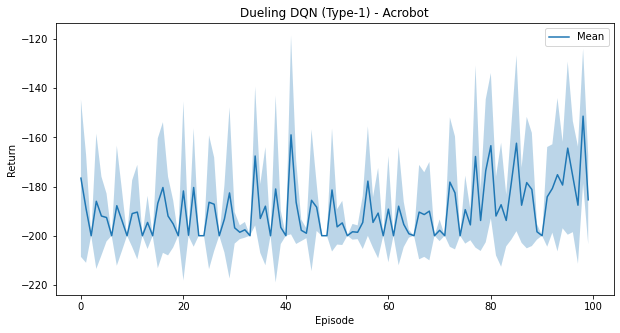

In [99]:
# Dueling DQN
# Acrobot-v1 using Type-1 update
env_name = "Acrobot-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=1)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# Acrobot-v1 using Type-2 update
env_name = "Acrobot-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=2)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "Acrobot-v1 Dueling DQN", "plots/dueling_dqn_acrobot_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "Acrobot-v1 Dueling DQN", "plots/dueling_dqn_acrobot_losses")


In [ ]:
# Dueling DQN
# CartPole-v1 using Type-1 update
env_name = "CartPole-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=1)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# CartPole-v1 using Type-2 update
env_name = "CartPole-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=2)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "CartPole-v1 Dueling DQN", "plots/dueling_dqn_cartpole_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "CartPole-v1 Dueling DQN", "plots/dueling_dqn_cartpole_losses")


In [ ]:
# Monte Carlo REINFORCE
# Acrobot-v1 without baseline
env_name = "Acrobot-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# Acrobot-v1 with baseline
env_name = "Acrobot-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "Acrobot-v1 REINFORCE", "plots/reinforce_acrobot_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "Acrobot-v1 REINFORCE", "plots/reinforce_acrobot_losses")


In [ ]:
# Monte Carlo REINFORCE
# CartPole-v1 without baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False)
rewards1, rewards_std1, losses1, losses_std1 = trainer.train()

# CartPole-v1 with baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True)
rewards2, rewards_std2, losses2, losses_std2 = trainer.train()

# Plots
plot_returns(rewards1, rewards_std1, rewards2, rewards_std2, "CartPole-v1 REINFORCE", "plots/reinforce_cartpole_returns")
plot_losses(losses1, losses_std1, losses2, losses_std2, "CartPole-v1 REINFORCE", "plots/reinforce_cartpole_losses")
